In [123]:
'''requirements.txt
geopy-2.4.0
folium-0.14.0
matplotlib-3.8.1
seaborn-0.13.0
Rtree-1.1.0
osmnx-1.7.1
geopandas-0.14.0
''';

In [8]:
# Uncomment if libs isn't installed 
'''
!pip install geopy
!pip install folium
!pip install matplotlib
!pip install seaborn
!pip install Rtree
!pip install osmnx geopandas sqlite3
!pip install requests --upgrade
!pip install osmnx --upgrade
''';

In [51]:
import sqlite3
import pandas as pd
# Libraries for geospesific calculations
from itertools import combinations
import time

import geopy
from geopy.distance import geodesic
# Visualisation of our data 
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
# For better documentation of our self mad functions 
from typing import List, Dict

import numpy as np

import seaborn as sns

from rtree import index


In [10]:
import warnings
warnings.simplefilter("ignore")

Входные данные:



3 csv файла - каждый файл -- это координаты gps, где человек находился какое-|то время


##### Информация
##### latitude - Широта
##### longitude - Долгота
Timestamp
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
Duration - продолжительность пребывания человека в локации в мс

## DataBase creation 

In [11]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

In [12]:
# Load the CSV files using the correct delimiter
person_1_df = pd.read_csv('person.1.csv', delimiter=';')
person_2_df = pd.read_csv('person.2.csv', delimiter=';')
person_3_df = pd.read_csv('person.3.csv', delimiter=';')

In [13]:
import os
# Initialize an empty list to hold all dataframes
all_dfs = []

# Loop to load CSV files
idx = 1
while True:
    file_name = f"person.{idx}.csv"
    if not os.path.exists(file_name):
        break  # Exit loop if file does not exist
    
    # Load the CSV file using the correct delimiter
    df = pd.read_csv(file_name, delimiter=';')
    
    # Add a 'person_id' column to distinguish between users
    df['person_id'] = idx
    
    # Append the dataframe to the list
    all_dfs.append(df)
    
    idx += 1

# Concatenate all loaded DataFrames into one
all_persons_df = pd.concat(all_dfs, ignore_index=True)

# Insert the concatenated DataFrame into the 'all_persons' table in the database
all_persons_df.to_sql('all_persons', conn, index=False)

# Return the number of unique persons loaded and the first few rows
unique_persons = all_persons_df['person_id'].nunique()
unique_persons, all_persons_df.head()


(3,
     latitude  longitude start_time(YYYYMMddHHmmZ)  duration(ms)  person_id
 0 -49.326958  -72.89073         201312251147-0300       1186491          1
 1 -49.326930  -72.89073         201312251213-0300       4393711          1
 2 -49.316610  -72.89890         201312251358-0300        842939          1
 3 -49.327160  -72.89072         201312251440-0300        211887          1
 4 -49.326880  -72.89085         201312251631-0300      71166228          1)

In [14]:
# Check if data has been inserted correctly by querying the first few rows from the 'all_persons' table
query_result_all = pd.read_sql_query("SELECT distinct person_id, count(*)  FROM all_persons GROUP BY 1 LIMIT 5", conn)
query_result_all


,person_id,count(*)
0,1,549
1,2,763
2,3,357


In [15]:
# Check if data has been inserted correctly by querying the first few rows from the 'all_persons' table
query_result_all = pd.read_sql_query("SELECT *  FROM all_persons", conn)
query_result_all


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms),person_id
0,-49.326958,-72.890730,201312251147-0300,1186491,1
1,-49.326930,-72.890730,201312251213-0300,4393711,1
2,-49.316610,-72.898900,201312251358-0300,842939,1
3,-49.327160,-72.890720,201312251440-0300,211887,1
4,-49.326880,-72.890850,201312251631-0300,71166228,1
...,...,...,...,...,...
1664,51.192430,4.398564,201403241720+0100,264,3
1665,51.049310,4.453596,201403241727+0100,238853,3
1666,50.898182,4.682842,201403241756+0100,119533,3
1667,50.955710,4.804546,201403241802+0100,62443,3


In [16]:
def get_data_from_db_or_csv(person_id: int, conn: sqlite3.Connection, csv_filename: str) -> pd.DataFrame:
    """
    Attempt to retrieve data for a user using an SQL query from the database. 
    If there's an error, fall back to reading the data from the CSV file.
    
    Args:
    - person_id (int): ID of the person (1, 2, or 3).
    - conn (sqlite3.Connection): Connection to the SQLite database.
    - csv_filename (str): Name of the CSV file to fall back to.
    
    Returns:
    - pd.DataFrame: Data for the user.
    """
    try:
        query = f"SELECT * FROM all_persons WHERE person_id = {person_id}"
        df = pd.read_sql_query(query, conn)
    except (sqlite3.OperationalError, sqlite3.DatabaseError):
        df = pd.read_csv(csv_filename, delimiter=';')
    return df

## Задание 1
- Посещали пользователи одинаковые места? Знают ли они друг друга?
- Ввести метрику социальной активности - она должна учитывать количество мест, которое посетил пользователь, как далеко они друг от друга и как долго человек оставался там - метрика должна позволять сравнивать пользователей и находить наиболее активных

### задание 1.1. Посещали пользователи одинаковые места? Знают ли они друг друга?

In [17]:
# Determine the number of unique users in the database
unique_person_ids = pd.read_sql_query("SELECT DISTINCT person_id FROM all_persons", conn)

# Create a dictionary to store dataframes for each user
dataframes_dict = {}

# Populate the dictionary with data for each user
for person_id in unique_person_ids['person_id']:
    csv_filename = f"person.{person_id}.csv"
    dataframes_dict[f"person_{person_id}_df_updated"] = get_data_from_db_or_csv(person_id, conn, csv_filename)

# Return the keys of the dictionary (i.e., the names of the dynamically created dataframes)
list(dataframes_dict.keys())

['person_1_df_updated', 'person_2_df_updated', 'person_3_df_updated']

In [18]:
dataframes_dict['person_1_df_updated'].head()

,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms),person_id
0,-49.326958,-72.89073,201312251147-0300,1186491,1
1,-49.326930,-72.89073,201312251213-0300,4393711,1
2,-49.316610,-72.89890,201312251358-0300,842939,1
3,-49.327160,-72.89072,201312251440-0300,211887,1
4,-49.326880,-72.89085,201312251631-0300,71166228,1


In [19]:
def process_dataframes(dataframes_dict: dict, precision: int = 3) -> dict:
    """
    Process each DataFrame in the dictionary: Convert the timestamp column to datetime format,
    and round the latitude and longitude values.
    
    Args:
    - dataframes_dict (dict): Dictionary containing data for each user.
    - precision (int): Rounding precision for latitude and longitude (default is 3).
    
    Returns:
    - Dictionary containing processed data for each user.
    """
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    # Convert the 'start_time(YYYYMMddHHmmZ)' column to datetime format for each DataFrame in the dictionary
    for key, df in dataframes_dict.items():
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    
    # Round the latitude and longitude values to the specified precision for each DataFrame in the dictionary
    for key, df in dataframes_dict.items():
        df[['latitude', 'longitude']] = df[['latitude', 'longitude']].round(precision)
    
    return dataframes_dict

In [20]:
processed_dataframes = process_dataframes(dataframes_dict, precision=3)
list(processed_dataframes.keys())  # Return the keys of the dictionary to confirm processing


['person_1_df_updated', 'person_2_df_updated', 'person_3_df_updated']

In [21]:
def compare_locations(dataframes_dict: dict) -> dict:
    """
    Compare locations between users in the provided dictionary to find common locations.
    
    Args:
    - dataframes_dict (dict): Dictionary containing processed data for each user.
    
    Returns:
    - Dictionary of common location counts between each pair of users.
    """
    
    # Create sets of tuples (latitude, longitude) for each person in the dictionary
    location_sets = {key: set(tuple(x) for x in df[['latitude', 'longitude']].values) for key, df in dataframes_dict.items()}
    
    # Find common locations between the users
    common_locations = {}
    keys = list(location_sets.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            key_pair = f"{keys[i]}_{keys[j]}"
            common_locations[key_pair] = location_sets[keys[i]].intersection(location_sets[keys[j]])
    
    common_location_counts = {key: len(value) for key, value in common_locations.items()}
    
    return common_location_counts

In [22]:
common_locs = compare_locations(processed_dataframes)
common_locs

{'person_1_df_updated_person_2_df_updated': 22,
 'person_1_df_updated_person_3_df_updated': 15,
 'person_2_df_updated_person_3_df_updated': 21}

In [23]:
# Decorator to measure execution time
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time for {func.__name__}: {end - start:.2f} seconds")
        return result
    return wrapper

In [28]:
# Define a function to check if two users have visited the same location within a certain time interval
@timing_decorator
def location_and_time_overlap(df1: pd.DataFrame,
                              df2: pd.DataFrame, location_threshold: float = 0.001,
                              time_threshold: pd.Timedelta = pd.Timedelta(minutes=15)) -> pd.DataFrame:
    """
    Checks for overlaps in location and time between two dataframes.
    
    Args:
    - df1, df2 (pd.DataFrame): Dataframes to compare.
    - location_threshold (float): Maximum allowed difference in location coordinates to consider them as the same.
    - time_threshold (pd.Timedelta): Maximum allowed time difference to consider two visits as overlapping.
    
    Returns:
    - pd.DataFrame: Overlapping entries from both dataframes.
    """
    overlaps = []
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    
    for idx1, row1 in df1.iterrows():
        for idx2, row2 in df2.iterrows():
            lat_diff = abs(row1['latitude'] - row2['latitude'])
            lon_diff = abs(row1['longitude'] - row2['longitude'])
            
            # Check if locations overlap
            if lat_diff <= location_threshold and lon_diff <= location_threshold:
                start_time_1 = row1[timestamp_col]
                end_time_1 = start_time_1 + pd.Timedelta(milliseconds=row1['duration(ms)'])
                
                start_time_2 = row2[timestamp_col]
                end_time_2 = start_time_2 + pd.Timedelta(milliseconds=row2['duration(ms)'])
                
                # Check if times overlap
                latest_start = max(start_time_1, start_time_2)
                earliest_end = min(end_time_1, end_time_2)
                delta = earliest_end - latest_start
                
                if delta >= pd.Timedelta(0) and delta <= time_threshold:
                    overlaps.append((row1, row2))
                    
    # Convert the overlaps to a DataFrame for better visualization
    overlap_df = pd.DataFrame({
        'Person_1_Lat': [row1['latitude'] for row1, _ in overlaps],
        'Person_1_Lon': [row1['longitude'] for row1, _ in overlaps],
        'Person_1_Time': [row1[timestamp_col] for row1, _ in overlaps],
        'Person_2_Lat': [row2['latitude'] for _, row2 in overlaps],
        'Person_2_Lon': [row2['longitude'] for _, row2 in overlaps],
        'Person_2_Time': [row2[timestamp_col] for _, row2 in overlaps],
    })
    
    return overlap_df

In [26]:
@timing_decorator
def location_and_time_overlap_vectorized(df1: pd.DataFrame,
                                         df2: pd.DataFrame, 
                                         location_threshold: float = 0.001,
                                         time_threshold: pd.Timedelta = pd.Timedelta(minutes=15)) -> pd.DataFrame:
    """
    Checks for overlaps in location and time between two dataframes using vectorized operations.
    
    Args:
    - df1, df2 (pd.DataFrame): Dataframes to compare.
    - location_threshold (float): Maximum allowed difference in location coordinates to consider them as the same.
    - time_threshold (pd.Timedelta): Maximum allowed time difference to consider two visits as overlapping.
    
    Returns:
    - pd.DataFrame: Overlapping entries from both dataframes.
    """
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    # Calculate the start and end times for each row in both dataframes
    df1['start_time'] = df1[timestamp_col]
    df1['end_time'] = df1['start_time'] + pd.to_timedelta(df1['duration(ms)'], unit='ms')
    
    df2['start_time'] = df2[timestamp_col]
    df2['end_time'] = df2['start_time'] + pd.to_timedelta(df2['duration(ms)'], unit='ms')
    
    # Cross join the dataframes to compare every location of one user against every location of another user
    df1['key'] = 1
    df2['key'] = 1
    combined = pd.merge(df1, df2, on='key').drop('key', axis=1)
    
    # Filter rows where locations overlap and times overlap
    location_overlap = (combined['latitude_x'].sub(combined['latitude_y']).abs().le(location_threshold)) & \
                       (combined['longitude_x'].sub(combined['longitude_y']).abs().le(location_threshold))
    
    time_overlap = (combined['start_time_x'].le(combined['end_time_y'])) & \
                   (combined['start_time_y'].le(combined['end_time_x']))
    
    overlap_rows = combined[location_overlap & time_overlap].copy()
    
    # Filter only the necessary columns and rename them for clarity
    overlap_df = overlap_rows[['latitude_x', 'longitude_x', 'start_time_x', 'latitude_y', 'longitude_y', 'start_time_y']]
    overlap_df.columns = ['Person_1_Lat', 'Person_1_Lon', 'Person_1_Time', 'Person_2_Lat', 'Person_2_Lon', 'Person_2_Time']
    
    return overlap_df


In [27]:
overlap_results = {}

# Iterate over every combination of 2 dataframes in the dataframes_dict
for key1, key2 in combinations(dataframes_dict.keys(), 2):
    # Get the overlap dataframe for the current combination
    overlap_df = location_and_time_overlap_vectorized(dataframes_dict[key1], dataframes_dict[key2])
    
    # Store the overlap dataframe in the overlap_results dictionary
    overlap_key = f"{key1}_{key2}"
    overlap_results[overlap_key] = overlap_df

# This will provide the overlaps for all combinations: person_1_person_2, person_1_person_3, and person_2_person_3.
overlap_results.keys()


Execution time for location_and_time_overlap_vectorized: 2.16 seconds
Execution time for location_and_time_overlap_vectorized: 1.00 seconds
Execution time for location_and_time_overlap_vectorized: 0.06 seconds


dict_keys(['person_1_df_updated_person_2_df_updated', 'person_1_df_updated_person_3_df_updated', 'person_2_df_updated_person_3_df_updated'])

In [39]:
# Create a base map
m = folium.Map(location=[51.207, 4.387], zoom_start=13)

# Extract locations from both dataframes
locations_1 = processed_dataframes['person_1_df_updated'][['latitude', 'longitude']].values.tolist()
locations_2 = processed_dataframes['person_2_df_updated'][['latitude', 'longitude']].values.tolist()
locations_3 = processed_dataframes['person_3_df_updated'][['latitude', 'longitude']].values.tolist()

# Combine the locations
all_locations = locations_1 + locations_2 + locations_3

# Create a heatmap
HeatMap(all_locations).add_to(m)

m

In [37]:
# Create a base map
m = folium.Map(location=[51.207, 4.387], zoom_start=13)

# Extract locations from both dataframes
locations_2 = processed_dataframes['person_1_df_updated'][['latitude', 'longitude']].values.tolist()
locations_3 = processed_dataframes['person_2_df_updated'][['latitude', 'longitude']].values.tolist()

# Combine the locations
all_locations = locations_2 + locations_3

# Create a heatmap
HeatMap(all_locations).add_to(m)

m

In [38]:
# Create a base map
m = folium.Map(location=[51.207, 4.387], zoom_start=13)

# Extract locations from both dataframes
locations_2 = processed_dataframes['person_1_df_updated'][['latitude', 'longitude']].values.tolist()
locations_3 = processed_dataframes['person_3_df_updated'][['latitude', 'longitude']].values.tolist()

# Combine the locations
all_locations = locations_2 + locations_3

# Create a heatmap
HeatMap(all_locations).add_to(m)

m

In [57]:
# Create a base map
m = folium.Map(location=[51.207, 4.387], zoom_start=13)

# Extract locations from both dataframes
locations_2 = person_2_df_updated[['latitude', 'longitude']].values.tolist()
locations_3 = person_3_df_updated[['latitude', 'longitude']].values.tolist()

# Combine the locations
all_locations = locations_2 + locations_3

# Create a heatmap
HeatMap(all_locations).add_to(m)

m

In [58]:
# Here's a heatmap visualization of the locations visited by both Persons 2 and 3. The map displays areas with higher visit frequencies in more intense colors.

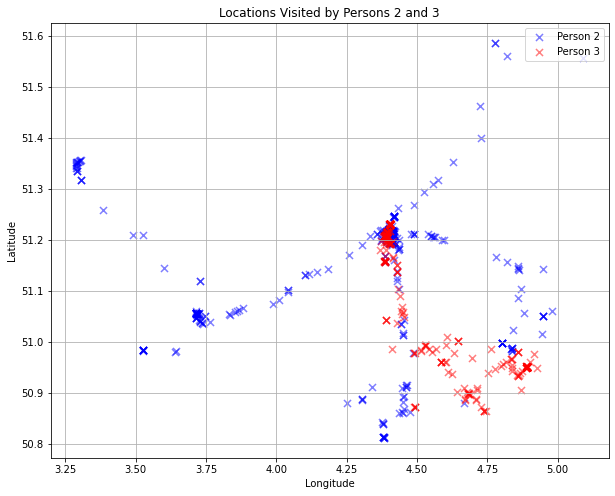

In [63]:
# Extract latitude and longitude values for each user
lat_2, lon_2 = person_2_df_updated['latitude'].values, person_2_df_updated['longitude'].values
lat_3, lon_3 = person_3_df_updated['latitude'].values, person_3_df_updated['longitude'].values

# Plot the scatter plot with cross markers
plt.figure(figsize=(10, 8))
plt.scatter(lon_2, lat_2, c='blue', label='Person 2', alpha=0.5, s=50, marker='x')
plt.scatter(lon_3, lat_3, c='red', label='Person 3', alpha=0.5, s=50, marker='x')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations Visited by Persons 2 and 3')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

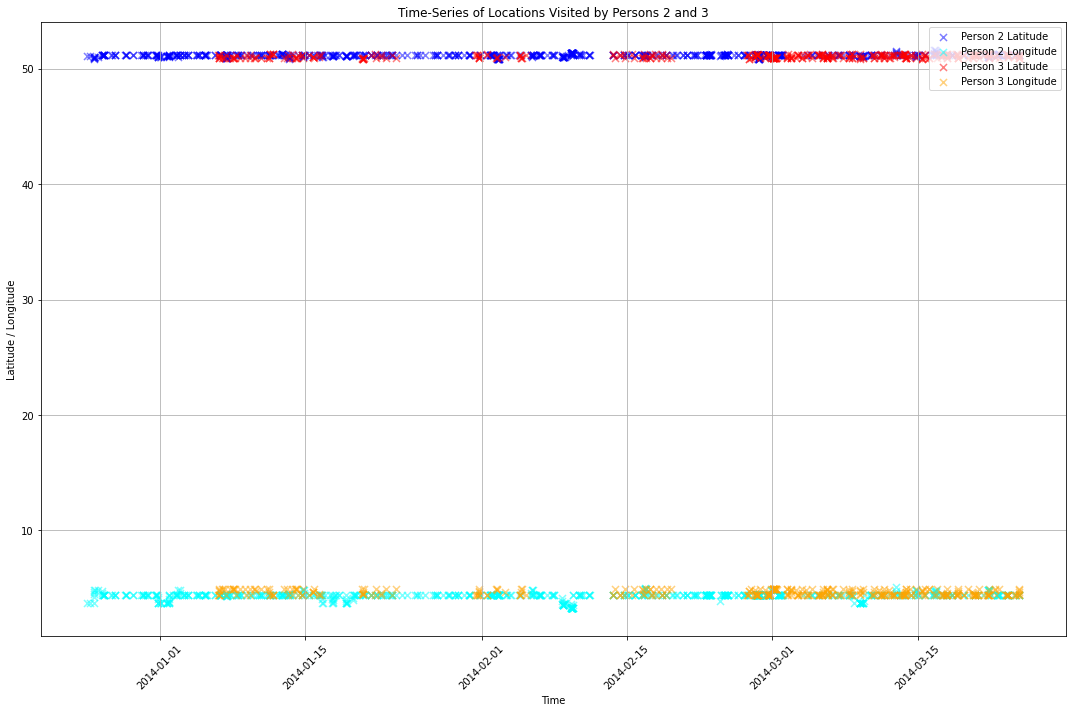

In [65]:
# Plot the time-series plot
plt.figure(figsize=(15, 10))

# Plot for Person 2
plt.scatter(person_2_df_updated[timestamp_col], lat_2, c='blue', label='Person 2 Latitude', alpha=0.5, s=50, marker='x')
plt.scatter(person_2_df_updated[timestamp_col], lon_2, c='cyan', label='Person 2 Longitude', alpha=0.5, s=50, marker='x')

# Plot for Person 3
plt.scatter(person_3_df_updated[timestamp_col], lat_3, c='red', label='Person 3 Latitude', alpha=0.5, s=50, marker='x')
plt.scatter(person_3_df_updated[timestamp_col], lon_3, c='orange', label='Person 3 Longitude', alpha=0.5, s=50, marker='x')

plt.xlabel('Time')
plt.ylabel('Latitude / Longitude')
plt.title('Time-Series of Locations Visited by Persons 2 and 3')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### задание 1.2. Ввести метрику социальной активности - она должна учитывать количество мест, которое посетил пользователь, как далеко они друг от друга и как долго человек оставался там - метрика должна позволять сравнивать пользователей и находить наиболее активных

In [33]:
def average_distance_between_places(df:pd.DataFrame) -> int:
    """Calculate the average distance between consecutive places visited by the user."""
    distances = []
    for i in range(1, len(df)):
        lat_lon_1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        lat_lon_2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        distances.append(geodesic(lat_lon_1, lat_lon_2).kilometers)
    return sum(distances) / len(distances) if distances else 0


To define a social activity metric, I'll consider the following factors:

### Number of Places Visited (NPV):
Represents the total number of unique places the person has visited.
### Average Distance Between Places (ADBP):
Represents the average distance between consecutive places visited by the user. This gives an indication of how far they travel between destinations.
### Average Duration at Places (ADAP):
Represents the average time spent at each location.
### The Social Activity Metric (SAM) can be formulated as:

SAM =
NPV
+
ADBP
+
ADAP




In [34]:
@timing_decorator
def calculate_social_activity_metric_v1(dfs_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Calculate the original social activity metric for each DataFrame in the provided dictionary, 
    but format the output as a DataFrame.
    
    Args:
    - dfs_dict (Dict[str, pd.DataFrame]): Dictionary of DataFrames containing location data for different users.
    
    Returns:
    - pd.DataFrame: DataFrame containing the calculated metrics for each user.
    """
    metrics = []
    for person_name, df in dfs_dict.items():
        NPV = len(set(tuple(x) for x in df[['latitude', 'longitude']].values))
        ADBP = average_distance_between_places(df)
        ADAP = df['duration(ms)'].mean() / (1000 * 60)  # Convert from ms to minutes
        SAM = NPV + ADBP + ADAP
        metrics.append({
            "Person": person_name,
            "NPV": NPV,
            "ADBP": ADBP,
            "ADAP": ADAP,
            "SAM": SAM
        })
    
    return pd.DataFrame(metrics)

In [35]:
# Order the DataFrame by SAM from highest to lowest and return the result
social_activity_metric_v1 = calculate_social_activity_metric_v1(dataframes_dict)
social_activity_metric_v1 = social_activity_metric_v1.sort_values(by='SAM', ascending=False).reset_index(drop=True)
social_activity_metric_v1


Execution time for calculate_social_activity_metric_v1: 1.12 seconds


,Person,NPV,ADBP,ADAP,SAM
0,person_2_df_updated,297,3.462041,149.929435,450.391475
1,person_1_df_updated,237,34.677874,173.681145,445.359018
2,person_3_df_updated,145,13.252757,156.538376,314.791133


Person 2 appears to be the most socially active, with the highest SAM value of 450.39.
Person 1 follows closely behind with a SAM value of 445.36.
Person 3 has the lowest SAM value of 314.79.

# SAM
$ SAM = NPV × f(ADBP, ADAP) $

## Where:
$ f(ADBP, ADAP) $ is a function that gives the average weight of a place using the Average Distance Between Places (ADBP) and the Average Duration at Places (ADAP).

## Definition of f:
One possible definition of f is the harmonic mean of ADBP and ADAP:
$$ f(ADBP, ADAP) = \frac{2 × ADBP × ADAP}{ADBP + ADAP} $$

The harmonic mean gives a balanced weight to both ADBP and ADAP. If one of them is very small while the other is large, the harmonic mean will be closer to the smaller value. This ensures that both the distance between places and the duration at places have an influential role in determining the weight of a place.


In [37]:
def harmonic_mean(x: float, y: float) -> float:
    """Calculate the harmonic mean of two numbers."""
    if x == 0 or y == 0:
        return 0
    return (2 * x * y) / (x + y)

In [38]:
@timing_decorator
def calculate_social_activity_metric_v2(dfs_dict: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Calculate the updated social activity metric for each DataFrame in the provided dictionary.
    
    Args:
    - dfs_dict (Dict[str, pd.DataFrame]): Dictionary of DataFrames containing location data for different users.
    
    Returns:
    - pd.DataFrame: DataFrame containing the calculated metrics for each user.
    """
    metrics = []
    for person_name, df in dfs_dict.items():
        NPV = len(set(tuple(x) for x in df[['latitude', 'longitude']].values))
        ADBP = average_distance_between_places(df)
        ADAP = df['duration(ms)'].mean() / (1000 * 60)  # Convert from ms to minutes
        weight = harmonic_mean(ADBP, ADAP)
        SAM = NPV * weight
        metrics.append({
            "Person": person_name,
            "NPV": NPV,
            "ADBP": ADBP,
            "ADAP": ADAP,
            "Weight": weight,
            "SAM": SAM
        })
    
    return pd.DataFrame(metrics)


In [39]:
social_activity_metric_v2 = calculate_social_activity_metric_v2(dataframes_dict)
social_activity_metric_v2 = social_activity_metric_v2.sort_values(by='SAM', ascending=False).reset_index(drop=True)
social_activity_metric_v2

Execution time for calculate_social_activity_metric_v2: 1.10 seconds


,Person,NPV,ADBP,ADAP,Weight,SAM
0,person_1_df_updated,237,34.677874,173.681145,57.812643,13701.596454
1,person_3_df_updated,145,13.252757,156.538376,24.436672,3543.317380
2,person_2_df_updated,297,3.462041,149.929435,6.767805,2010.038095


In [41]:
# Extract day of the week and hour of the day separately and then join them

def extract_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    day_of_week = df[timestamp_col].dt.dayofweek
    hour_of_day = df[timestamp_col].dt.hour
    df_temp = df.copy()
    df_temp['day_of_week'] = day_of_week
    df_temp['hour_of_day'] = hour_of_day
    return df_temp

# Apply the function to the dataframes
person_1_temporal = extract_temporal_features(dataframes_dict['person_1_df_updated'])


# Display the results
person_1_temporal.head()


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms),person_id,start_time,end_time,key,day_of_week,hour_of_day
0,-49.327,-72.891,2013-12-25 11:47:00-03:00,1186491,1,2013-12-25 11:47:00-03:00,2013-12-25 12:06:46.491000-03:00,1,2.0,11.0
1,-49.327,-72.891,2013-12-25 12:13:00-03:00,4393711,1,2013-12-25 12:13:00-03:00,2013-12-25 13:26:13.711000-03:00,1,2.0,12.0
2,-49.317,-72.899,2013-12-25 13:58:00-03:00,842939,1,2013-12-25 13:58:00-03:00,2013-12-25 14:12:02.939000-03:00,1,2.0,13.0
3,-49.327,-72.891,2013-12-25 14:40:00-03:00,211887,1,2013-12-25 14:40:00-03:00,2013-12-25 14:43:31.887000-03:00,1,2.0,14.0
4,-49.327,-72.891,2013-12-25 16:31:00-03:00,71166228,1,2013-12-25 16:31:00-03:00,2013-12-26 12:17:06.228000-03:00,1,2.0,16.0


## Plotting
### By day of the week

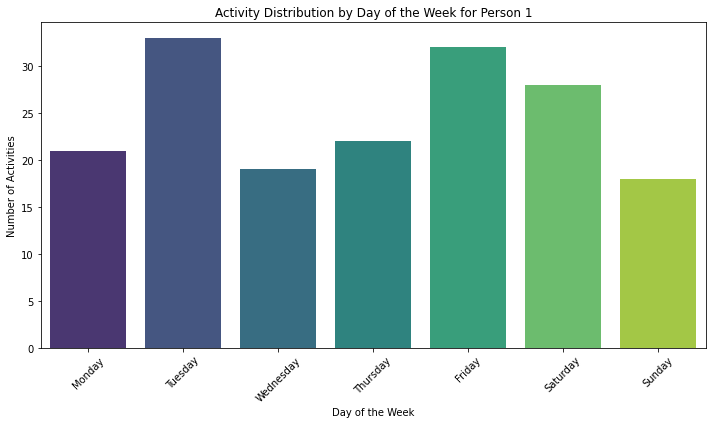

In [42]:
# Activity Distribution by Day of the Week for person_1
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daywise_counts = person_1_temporal['day_of_week'].value_counts().sort_index()
daywise_counts.index = days

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=daywise_counts.index, y=daywise_counts.values, palette="viridis")
plt.title('Activity Distribution by Day of the Week for Person 1')
plt.ylabel('Number of Activities')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


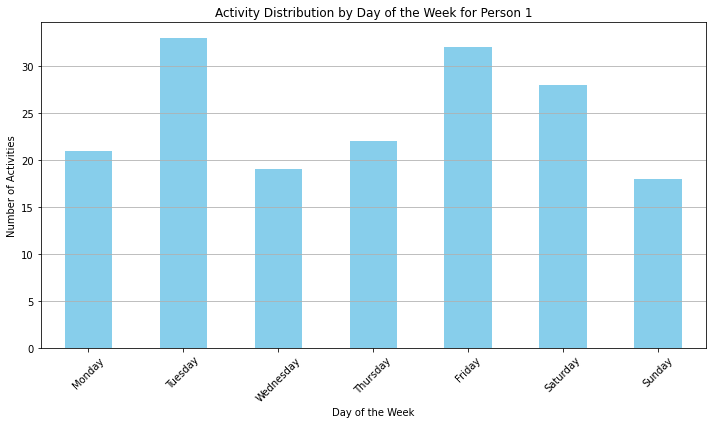

In [43]:
plt.figure(figsize=(10, 6))
daywise_counts.plot(kind='bar', color='skyblue')
plt.title('Activity Distribution by Day of the Week for Person 1')
plt.ylabel('Number of Activities')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [44]:
def extract_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts day of the week and hour of the day from the timestamp column of the dataframe.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the location data with timestamp.
    
    Returns:
    - pd.DataFrame: DataFrame with additional columns for day of the week and hour of the day.
    """
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df['day_of_week'] = df[timestamp_col].dt.dayofweek
    df['hour_of_day'] = df[timestamp_col].dt.hour
    return df

In [45]:
# Test the functions for person 1
person_1_temporal = extract_temporal_features(dataframes_dict['person_1_df_updated'])
person_2_temporal = extract_temporal_features(dataframes_dict['person_2_df_updated'])
person_3_temporal = extract_temporal_features(dataframes_dict['person_3_df_updated'])

In [46]:
def plot_daywise_activity_with_mean(df: pd.DataFrame, person_name: str) -> None:
    """
    Plot the activity distribution by day of the week for the given dataframe.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the location data.
    - person_name (str): Name of the person (for title purposes).
    
    Returns:
    - None: Displays the plot.
    """
    # Count the number of records for each day of the week
    daywise_counts = df['day_of_week'].value_counts().sort_index()
    
    # Calculate the mean interactions per day
    mean_interaction_per_day = daywise_counts.mean()
    
    # Plot
    plt.figure(figsize=(10, 6))
    daywise_counts.plot(kind='bar', color='skyblue', label='Interactions per Day')
    plt.axhline(y=mean_interaction_per_day, color='r', linestyle='-', label=f'Mean Interactions per Day: {mean_interaction_per_day:.2f}')
    plt.title(f'Activity Distribution by Day of the Week for {person_name}')
    plt.ylabel('Number of Activities')
    plt.xlabel('Day of the Week')
    plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.legend()
    plt.show()



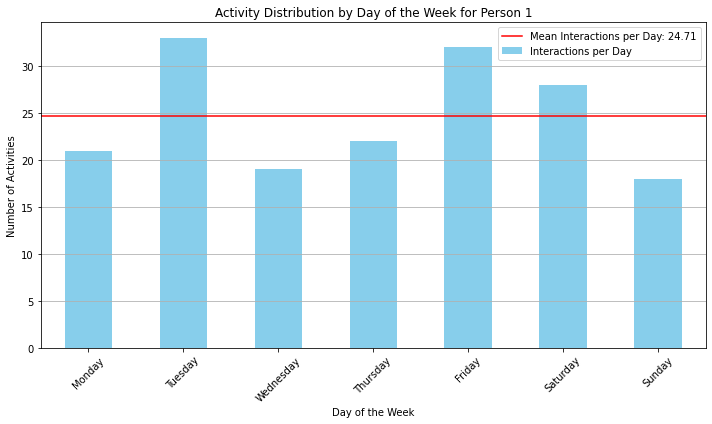

In [47]:
# Test the function
plot_daywise_activity_with_mean(person_1_temporal, 'Person 1')

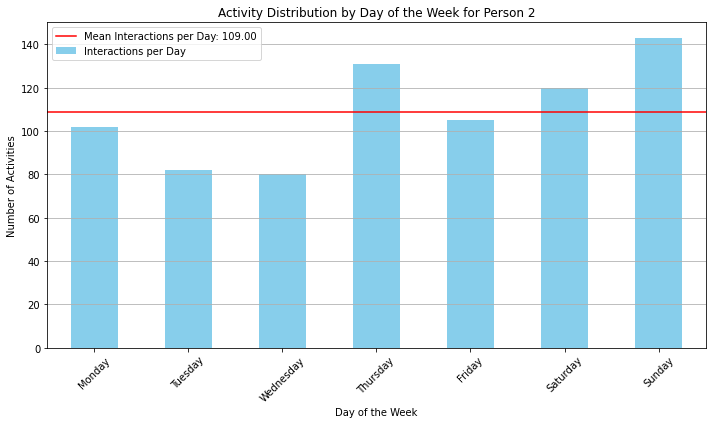

In [48]:

# Test the function
plot_daywise_activity_with_mean(person_2_temporal, 'Person 2')

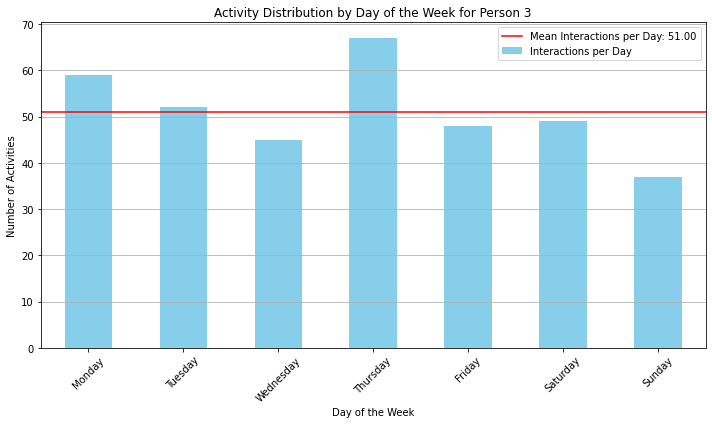

In [49]:

# Test the function
plot_daywise_activity_with_mean(person_3_temporal, 'Person 3')

### By time of the day

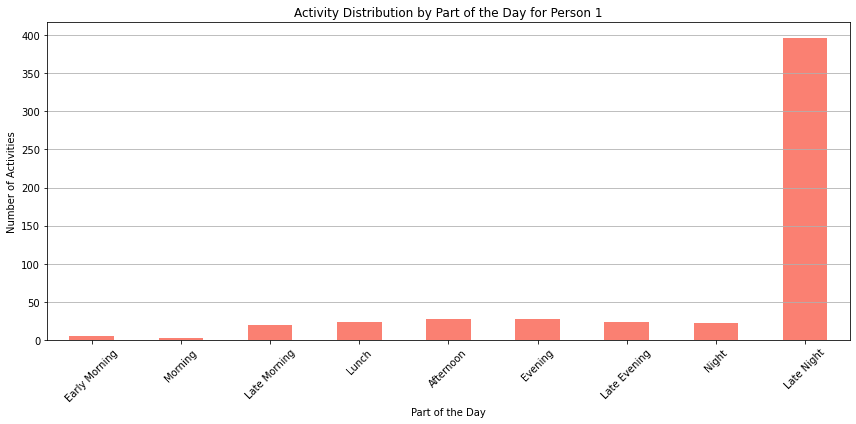

In [52]:
def categorize_time_of_day(hour: int) -> str:
    """
    Categorize the hour into different parts of the day.
    """
    if 4 <= hour < 7:
        return "Early Morning"
    elif 7 <= hour < 10:
        return "Morning"
    elif 10 <= hour < 12:
        return "Late Morning"
    elif 12 <= hour < 14:
        return "Lunch"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 22:
        return "Late Evening"
    elif 22 <= hour < 24:
        return "Night"
    else:
        return "Late Night"

# Apply the categorization function to the temporal dataframe
person_1_temporal['part_of_day'] = person_1_temporal['hour_of_day'].apply(categorize_time_of_day)

# Plotting the distribution
plt.figure(figsize=(12, 6))
person_1_temporal['part_of_day'].value_counts().reindex([
    "Early Morning", "Morning", "Late Morning", "Lunch", "Afternoon", 
    "Evening", "Late Evening", "Night", "Late Night"
]).plot(kind='bar', color='salmon')
plt.title('Activity Distribution by Part of the Day for Person 1')
plt.ylabel('Number of Activities')
plt.xlabel('Part of the Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [53]:
def extract_part_of_day_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extract the part of the day (early morning, morning, ... etc.) from the timestamp.
    
    Args:
    - df (pd.DataFrame): Input dataframe with timestamp data.
    
    Returns:
    - pd.DataFrame: DataFrame with an additional 'part_of_day' column.
    """
    timestamp_col = 'start_time(YYYYMMddHHmmZ)'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    hour_of_day = df[timestamp_col].dt.hour
    conditions = [
        (hour_of_day >= 0) & (hour_of_day < 6),
        (hour_of_day >= 6) & (hour_of_day < 9),
        (hour_of_day >= 9) & (hour_of_day < 12),
        (hour_of_day >= 12) & (hour_of_day < 14),
        (hour_of_day >= 14) & (hour_of_day < 17),
        (hour_of_day >= 17) & (hour_of_day < 20),
        (hour_of_day >= 20) & (hour_of_day <= 23)
    ]
    choices = ['Early Morning', 'Morning', 'Late Morning', 'Lunch', 'Afternoon', 'Evening', 'Night']
    df['part_of_day'] = np.select(conditions, choices, default='Unknown')
    return df

def plot_activity_by_part_of_day(df: pd.DataFrame, person_name: str):
    """
    Generate a bar plot showing activity distribution for different parts of the day.
    
    Args:
    - df (pd.DataFrame): DataFrame with 'part_of_day' column.
    - person_name (str): Name of the person for which the plot is generated.
    """
    plt.figure(figsize=(12, 6))
    df['part_of_day'].value_counts().reindex([
        'Early Morning', 'Morning', 'Late Morning', 'Lunch', 'Afternoon', 'Evening', 'Night'
    ]).plot(kind='bar', color='skyblue')
    plt.title(f'Activity Distribution by Part of the Day for {person_name}')
    plt.ylabel('Number of Activities')
    plt.xlabel('Part of the Day')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

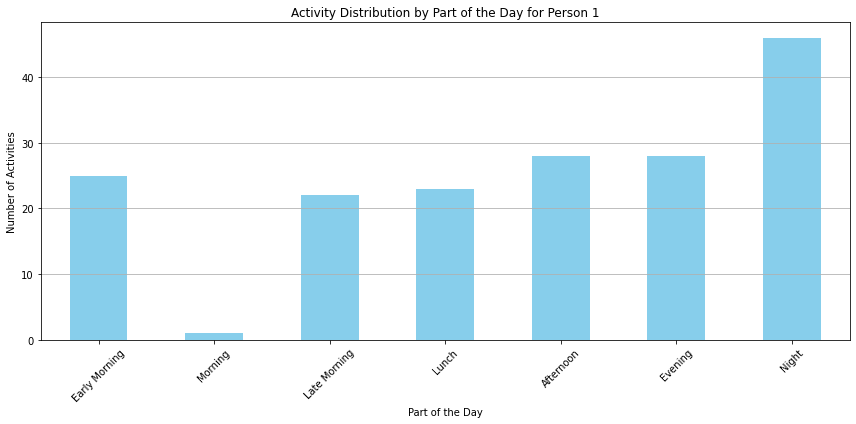

In [54]:
# Test the functions
person_1_part_of_day = extract_part_of_day_features(dataframes_dict['person_1_df_updated'])
plot_activity_by_part_of_day(person_1_part_of_day, 'Person 1')


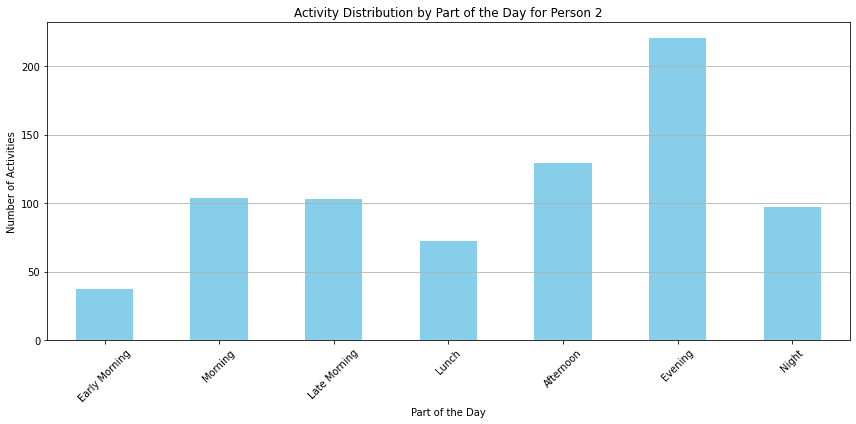

In [55]:
# Test the functions
person_2_part_of_day = extract_part_of_day_features(dataframes_dict['person_2_df_updated'])
plot_activity_by_part_of_day(person_2_part_of_day, 'Person 2')


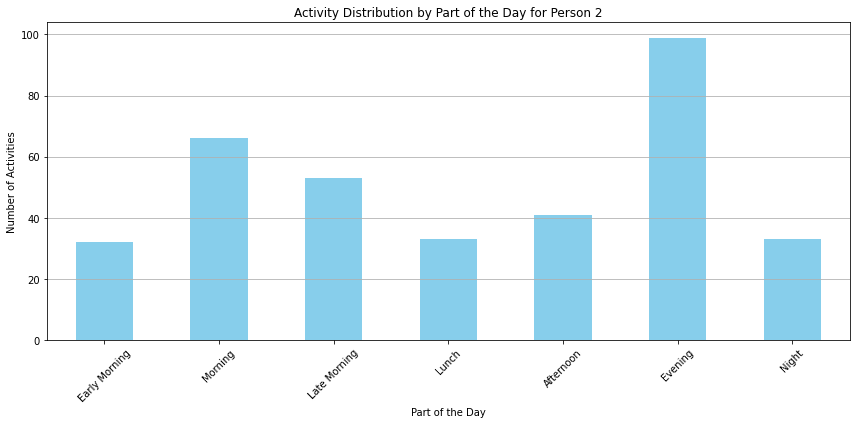

In [56]:
# Test the functions
person_3_part_of_day = extract_part_of_day_features(dataframes_dict['person_3_df_updated'])
plot_activity_by_part_of_day(person_3_part_of_day, 'Person 2')


## Another option to calculate sam using day specification

In [57]:
PARTS_OF_DAY = {
    "Early Morning": (0, 6, 0.5),
    "Morning": (6, 12, 1),
    "Afternoon": (12, 17, 1.5),
    "Evening": (17, 21, 2),
    "Night": (21, 24, 1)
}


In [58]:
def calculate_weighted_sam(df: pd.DataFrame) -> float:
    """
    Calculate the Social Activity Metric (SAM) based on the weighted importance of different parts of the day.
    
    Args:
    - df (pd.DataFrame): DataFrame containing the temporal features of a user's activities.
    
    Returns:
    - float: Weighted SAM for the user.
    """
    weighted_sam = 0
    total_weight = sum([weight for _, _, weight in PARTS_OF_DAY.values()])
    
    for part, (start_hour, end_hour, weight) in PARTS_OF_DAY.items():
        part_df = df[(df['hour_of_day'] >= start_hour) & (df['hour_of_day'] < end_hour)]
        average_activities = part_df.shape[0] / len(df['day_of_week'].unique())
        weighted_sam += average_activities * weight
    
    return weighted_sam / total_weight

# Calculate the weighted SAM for each user and store the results in a dictionary
weighted_sam_dict = {}
for person, df in processed_dataframes.items():
    weighted_sam_dict[person] = calculate_weighted_sam(df)

weighted_sam_dict


{'person_1_df_updated': 4.6875,
 'person_2_df_updated': 25.90476190476191,
 'person_3_df_updated': 11.904761904761905}

In [59]:
'person_2 >> person_3 >> person_1';

In [60]:
def weighted_adap(df: pd.DataFrame, weights: dict) -> float:
    """
    Compute the weighted Average Duration At Places (ADAP) based on parts of the day.
    
    Args:
    - df (pd.DataFrame): DataFrame containing user data with 'hour_of_day' and 'duration(ms)' columns.
    - weights (dict): A dictionary mapping parts of the day to their weights.
    
    Returns:
    - float: The weighted ADAP.
    """
    total_weighted_duration = 0
    total_weight = 0
    
    for part, (start, end) in PARTS_OF_DAY.items():
        mask = (df['hour_of_day'] >= start) & (df['hour_of_day'] < end)
        segment_duration = df[mask]['duration(ms)'].sum() / (1000 * 60)  # Convert to minutes
        total_weighted_duration += segment_duration * weights[part]
        total_weight += weights[part]
    
    return total_weighted_duration / total_weight


In [61]:
def calculate_social_activity_metric_weighted(df: pd.DataFrame, weights: dict) -> dict:
    """
    Calculate the Social Activity Metric (SAM) with weighted ADAP.
    
    Args:
    - df (pd.DataFrame): DataFrame containing user data.
    - weights (dict): A dictionary mapping parts of the day to their weights.
    
    Returns:
    - dict: A dictionary containing NPV, ADBP, weighted ADAP, and SAM values.
    """
    NPV = len(set(tuple(x) for x in df[['latitude', 'longitude']].values))
    ADBP = average_distance_between_places(df)
    ADAP_weighted = weighted_adap(df, weights)
    SAM = NPV + ADBP + ADAP_weighted
    
    return {
        "NPV": NPV,
        "ADBP": ADBP,
        "Weighted ADAP": ADAP_weighted,
        "SAM": SAM
    }


In [62]:
PARTS_OF_DAY = {
    'early_morning': (0, 6),
    'morning': (6, 12),
    'afternoon': (12, 17),
    'evening': (17, 21),
    'night': (21, 24)
}

WEIGHTS = {
    'early_morning': 0.5,
    'morning': 1,
    'afternoon': 1.5,
    'evening': 2,
    'night': 0.5
}


In [63]:
modified_sam_values = {}

for person, df in processed_dataframes.items():
    metrics = calculate_social_activity_metric_weighted(df, WEIGHTS)
    modified_sam_values[person] = metrics

# Convert results to a DataFrame for better visualization
modified_sam_df = pd.DataFrame(modified_sam_values).T


In [64]:
modified_sam_df

,NPV,ADBP,Weighted ADAP,SAM
person_1_df_updated,237.0,34.677874,2838.595383,3110.273257
person_2_df_updated,297.0,3.462041,27375.840591,27676.302632
person_3_df_updated,145.0,13.252757,15201.826730,15360.079487


In [65]:
def calculate_social_activity_metric_harmonic_v2(dfs, weights):
    """
    Calculate SAM using harmonic mean and part-of-day weights for each DataFrame.
    Args:
    - dfs (dict): Dictionary of DataFrames containing location data for different users.
    - weights (dict): Weights assigned to different parts of the day.
    
    Returns:
    - pd.DataFrame: DataFrame containing the calculated metrics for each user.
    """
    metrics = {}
    for person, df in dfs.items():
        NPV = len(set(tuple(x) for x in df[['latitude', 'longitude']].values))
        ADBP = average_distance_between_places(df)
        weighted_ADAP = weighted_adap(df, weights)
        weight = harmonic_mean(ADBP, weighted_ADAP)
        SAM = NPV * weight
        metrics[person] = {
            "NPV": NPV,
            "ADBP": ADBP,
            "Weighted ADAP": weighted_ADAP,
            "Weight": weight,
            "SAM": SAM
        }
    
    return pd.DataFrame(metrics).T



In [66]:
# Calculate the modified SAM for each person using harmonic mean
modified_sam_harmonic_df = calculate_social_activity_metric_harmonic_v2(processed_dataframes, WEIGHTS)
modified_sam_harmonic_df

,NPV,ADBP,Weighted ADAP,Weight,SAM
person_1_df_updated,237.0,34.677874,2838.595383,68.518685,16238.928279
person_2_df_updated,297.0,3.462041,27375.840591,6.923206,2056.192121
person_3_df_updated,145.0,13.252757,15201.826730,26.482427,3839.951948


## Check if clients know each other

In [70]:
@timing_decorator
def location_and_time_overlap_count_rtree(df1: pd.DataFrame, df2: pd.DataFrame, location_threshold: float = 0.00001, 
                                              time_threshold: pd.Timedelta = pd.Timedelta(minutes=1)) -> int:
    overlaps_count = 0
    
    # Step 1: Index df2 locations using R-tree
    idx = index.Index()
    for i, row in df2.iterrows():
        idx.insert(i, (row['longitude'], row['latitude'], row['longitude'], row['latitude']))
    
    # Step 2: Query R-tree using df1 locations
    for _, row1 in df1.iterrows():
        left, bottom = row1['longitude'] - location_threshold, row1['latitude'] - location_threshold
        right, top = row1['longitude'] + location_threshold, row1['latitude'] + location_threshold
        
        for j in idx.intersection((left, bottom, right, top)):
            row2 = df2.iloc[j]
            
            # Step 3: Temporal Filtering
            start_time_1 = row1['start_time(YYYYMMddHHmmZ)']
            end_time_1 = start_time_1 + pd.Timedelta(milliseconds=row1['duration(ms)'])
            start_time_2 = row2['start_time(YYYYMMddHHmmZ)']
            end_time_2 = start_time_2 + pd.Timedelta(milliseconds=row2['duration(ms)'])
            
            if max(start_time_1, start_time_2) <= min(end_time_1, end_time_2) + time_threshold:
                overlaps_count += 1
                
    return overlaps_count


In [71]:
# Check for overlaps between each pair of users using the optimized function
overlap_counts_v4 = {}
for i in range(1, len(processed_dataframes) + 1):
    for j in range(i + 1, len(processed_dataframes) + 1):
        overlap_counts_v4[f'Person_{i}_Person_{j}'] = location_and_time_overlap_count_rtree(
            processed_dataframes[f'person_{i}_df_updated'], 
            processed_dataframes[f'person_{j}_df_updated']
        )

overlap_counts_v4

Execution time for location_and_time_overlap_count_rtree: 0.88 seconds
Execution time for location_and_time_overlap_count_rtree: 0.50 seconds
Execution time for location_and_time_overlap_count_rtree: 0.68 seconds


{'Person_1_Person_2': 0, 'Person_1_Person_3': 0, 'Person_2_Person_3': 58}

In [ ]:
# Person 3 and 2 defenitely know each other because they have 58 1 meter overlaps that was for at leas 1 minute long =>
# That wasn't coincidence of any sort 

In [121]:
''' 
If users are related, that could be usefull for banking industry for example to make 
models as PD/LGD. Users with high credit risks would probably communicate with thouth who have high  risk and
vice a verca
''';

## Add external data from OpenStreetMap

In [75]:
# !conda create -n ox -c conda-forge --strict-channel-priority osmnx
# In terminal


# doesn't worked on my machine so decided to use just geopandas that is less convinient, but also solid instrument 

In [84]:
import geopandas
import geopandas as gpd
import requests
from shapely.geometry import Point

In [89]:
import requests
import geopandas as gpd
from shapely.geometry import Point

# Define the Overpass API endpoint
OVERPASS_API = "https://overpass-api.de/api/interpreter"

# Define the query to fetch all POIs in Amsterdam
query = """
[out:json];
area["name"="Amsterdam"]["admin_level"="8"];
node(area)[amenity];
out center;
"""

# Make the API request
response = requests.get(OVERPASS_API, params={'data': query})
data = response.json()

# Extract nodes from the response
nodes = data['elements']

# Create a GeoDataFrame from nodes
geometry = [Point(node['lon'], node['lat']) for node in nodes]
pois_gdf = gpd.GeoDataFrame(nodes, geometry=geometry)

# Save the GeoDataFrame to a file (optional)
pois_gdf.to_file("amsterdam_pois.geojson", driver='GeoJSON')

print(pois_gdf.head())


   type        id        lat       lon   
0  node  26611122  52.363773  4.911543  \
1  node  26612532  52.360459  4.929170   
2  node  26654662  52.383284  4.913121   
3  node  26654664  52.381326  4.913204   
4  node  26752359  52.358285  4.923750   

                                                tags                  geometry  
0  {'amenity': 'university', 'name': 'UvA Faculte...  POINT (4.91154 52.36377)  
1  {'addr:city': 'Amsterdam', 'addr:country': 'NL...  POINT (4.92917 52.36046)  
2  {'amenity': 'place_of_worship', 'building': 'm...  POINT (4.91312 52.38328)  
3  {'amenity': 'school', 'isced:level': '0;1', 'n...  POINT (4.91320 52.38133)  
4                            {'amenity': 'post_box'}  POINT (4.92375 52.35829)  


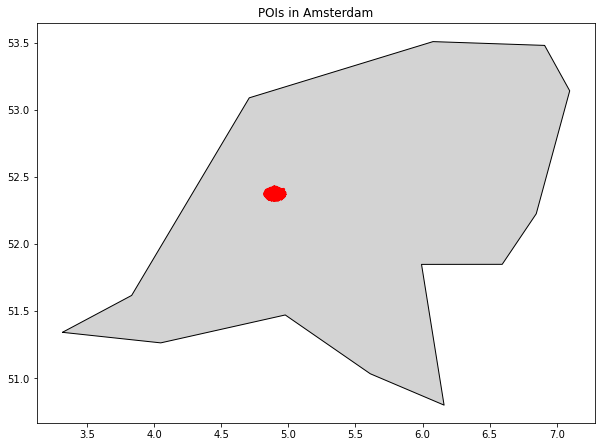

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Get the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Netherlands
netherlands = world[world['name'] == "Netherlands"]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
netherlands.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, markersize=5, color='red')
ax.set_title("POIs in Amsterdam")
plt.show()

In [92]:
def check_visits_to_amenities(person_gdf, pois_gdf, amenities_of_interest, distance_threshold=0.0001):
    """
    Check if a person visited specific amenities.
    
    Args:
    - person_gdf (GeoDataFrame): The person's movement data.
    - pois_gdf (GeoDataFrame): The POIs data.
    - amenities_of_interest (list): List of amenities to check.
    - distance_threshold (float): The distance threshold to consider a visit.
    
    Returns:
    - dict: Dictionary with amenity as the key and the count of visits as the value.
    """
    
    # Filter the POIs to only include the amenities of interest
    filtered_pois = pois_gdf[pois_gdf['amenity'].isin(amenities_of_interest)]
    
    visit_counts = {amenity: 0 for amenity in amenities_of_interest}
    
    # For each record in the person's data, check if they were near any of the filtered POIs
    for _, person_row in person_gdf.iterrows():
        for _, poi_row in filtered_pois.iterrows():
            if person_row['geometry'].distance(poi_row['geometry']) <= distance_threshold:
                visit_counts[poi_row['amenity']] += 1
                
    return visit_counts


In [96]:
# Extract 'amenity' from the 'tags' column and create a new 'amenity' column in the dataframe
pois_gdf['amenity'] = pois_gdf['tags'].apply(lambda x: x.get('amenity', None))

# Check the first few rows of the dataframe after extraction
pois_gdf.head()


,type,id,lat,lon,tags,geometry,amenity
0,node,26611122,52.363773,4.911543,"{'amenity': 'university', 'name': 'UvA Faculte...",POINT (4.91154 52.36377),university
1,node,26612532,52.360459,4.929170,"{'addr:city': 'Amsterdam', 'addr:country': 'NL...",POINT (4.92917 52.36046),fire_station
2,node,26654662,52.383284,4.913121,"{'amenity': 'place_of_worship', 'building': 'm...",POINT (4.91312 52.38328),place_of_worship
3,node,26654664,52.381326,4.913204,"{'amenity': 'school', 'isced:level': '0;1', 'n...",POINT (4.91320 52.38133),school
4,node,26752359,52.358285,4.923750,{'amenity': 'post_box'},POINT (4.92375 52.35829),post_box


In [99]:
from shapely.geometry import Point

# Convert latitude and longitude to geometry
person_1_gdf = gpd.GeoDataFrame(processed_dataframes['person_1_df_updated'], 
                                geometry=gpd.points_from_xy(processed_dataframes['person_1_df_updated'].longitude, 
                                                            processed_dataframes['person_1_df_updated'].latitude))

person_1_gdf.head()


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms),person_id,start_time,end_time,key,day_of_week,hour_of_day,part_of_day,geometry
0,-49.327,-72.891,2013-12-25 11:47:00-03:00,1186491,1,2013-12-25 11:47:00-03:00,2013-12-25 12:06:46.491000-03:00,1,2.0,11.0,Late Morning,POINT (-72.89100 -49.32700)
1,-49.327,-72.891,2013-12-25 12:13:00-03:00,4393711,1,2013-12-25 12:13:00-03:00,2013-12-25 13:26:13.711000-03:00,1,2.0,12.0,Lunch,POINT (-72.89100 -49.32700)
2,-49.317,-72.899,2013-12-25 13:58:00-03:00,842939,1,2013-12-25 13:58:00-03:00,2013-12-25 14:12:02.939000-03:00,1,2.0,13.0,Lunch,POINT (-72.89900 -49.31700)
3,-49.327,-72.891,2013-12-25 14:40:00-03:00,211887,1,2013-12-25 14:40:00-03:00,2013-12-25 14:43:31.887000-03:00,1,2.0,14.0,Afternoon,POINT (-72.89100 -49.32700)
4,-49.327,-72.891,2013-12-25 16:31:00-03:00,71166228,1,2013-12-25 16:31:00-03:00,2013-12-26 12:17:06.228000-03:00,1,2.0,16.0,Afternoon,POINT (-72.89100 -49.32700)


In [163]:
def calculate_enhanced_sam(user_gdf: gpd.GeoDataFrame,
                           pois_gdf: gpd.GeoDataFrame, distance_threshold: float = 0.00001) -> float:
    """
    Calculate the enhanced SAM score by incorporating visits to social amenities.
    
    Args:
    - user_gdf (gpd.GeoDataFrame): User location data.
    - pois_gdf (gpd.GeoDataFrame): Points of interest data.
    - distance_threshold (float): Threshold for considering a user's location to be at a POI.
    
    Returns:
    - float: Enhanced SAM score.
    """
    social_amenities = ['bar', 'cafe', 'club', 'restaurant', 'theater', 'cinema']
    social_pois = pois_gdf[pois_gdf['amenity'].isin(social_amenities)]
    
    # Check for visits to these social amenities
    visits_count = 0
    for _, user_row in user_gdf.iterrows():
        user_point = user_row['geometry']
        for _, poi_row in social_pois.iterrows():
            poi_point = poi_row['geometry']
            if user_point.distance(poi_point) <= distance_threshold:
                visits_count += 1
                break  # Break after the first match to avoid counting a visit multiple times
    
    # For demonstration, we're using a basic SAM calculation: Number of POIs visited.
    # This can be enhanced with more sophisticated metrics like duration, frequency, etc.
    enhanced_sam = visits_count
    return enhanced_sam

# Calculate the enhanced SAM for person 1
enhanced_sam_person_1 = calculate_enhanced_sam(person_1_gdf, pois_gdf)
enhanced_sam_person_1


0

In [101]:
def create_geodataframe(df, lat_col='latitude', lon_col='longitude') -> gpd.GeoDataFrame:
    """
    Convert a DataFrame with latitude and longitude columns to a GeoDataFrame.

    Args:
    - df (pd.DataFrame): The original DataFrame.
    - lat_col (str): The name of the column containing latitude values.
    - lon_col (str): The name of the column containing longitude values.

    Returns:
    - gpd.GeoDataFrame: A GeoDataFrame with the points created from latitude and longitude.
    """
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]))
    return gdf

# Usage example
person_1_gdf = create_geodataframe(processed_dataframes['person_1_df_updated'])
person_2_gdf = create_geodataframe(processed_dataframes['person_2_df_updated'])
person_3_gdf = create_geodataframe(processed_dataframes['person_3_df_updated'])

In [103]:
# Calculate the enhanced SAM for person 1
enhanced_sam_person_1 = calculate_enhanced_sam(person_1_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_1

3

In [102]:
# Calculate the enhanced SAM for person 1
enhanced_sam_person_2 = calculate_enhanced_sam(person_2_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_2

7

In [104]:
# Calculate the enhanced SAM for person 1
enhanced_sam_person_3 = calculate_enhanced_sam(person_3_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_3

0

In [105]:
@timing_decorator
def calculate_enhanced_sam_optimized(user_gdf: gpd.GeoDataFrame, 
                                     pois_gdf: gpd.GeoDataFrame, distance_threshold: float = 0.001) -> float:
    """
    Calculate the enhanced SAM score by incorporating visits to social amenities using optimized approach.
    
    Args:
    - user_gdf (gpd.GeoDataFrame): User location data.
    - pois_gdf (gpd.GeoDataFrame): Points of interest data.
    - distance_threshold (float): Threshold for considering a user's location to be at a POI.
    
    Returns:
    - float: Enhanced SAM score.
    """
    social_amenities = ['bar', 'cafe', 'club', 'restaurant', 'theater', 'cinema']
    social_pois = pois_gdf[pois_gdf['amenity'].isin(social_amenities)]
    
    # Create a buffer around each user's point based on the distance threshold
    user_gdf['geometry'] = user_gdf.buffer(distance_threshold)
    
    # Use spatial join to find overlaps between user locations and POIs
    joined = gpd.sjoin(user_gdf, social_pois, how="inner", op="intersects")
    
    # The length of the joined GeoDataFrame gives the number of overlaps
    visits_count = len(joined)
    
    # For demonstration, we're using a basic SAM calculation: Number of POIs visited.
    # This can be enhanced with more sophisticated metrics like duration, frequency, etc.
    enhanced_sam = visits_count
    return enhanced_sam

In [106]:
# Calculate the enhanced SAM for person 1 using the optimized function
enhanced_sam_person_1_optimized = calculate_enhanced_sam_optimized(person_1_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_1_optimized

Execution time for calculate_enhanced_sam_optimized: 0.03 seconds


122

In [107]:
# Calculate the enhanced SAM for person 1 using the optimized function
enhanced_sam_person_2_optimized = calculate_enhanced_sam_optimized(person_2_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_2_optimized

Execution time for calculate_enhanced_sam_optimized: 0.05 seconds


14841

In [108]:
# Calculate the enhanced SAM for person 1 using the optimized function
enhanced_sam_person_3_optimized = calculate_enhanced_sam_optimized(person_3_gdf, pois_gdf,distance_threshold=1)
enhanced_sam_person_3_optimized

Execution time for calculate_enhanced_sam_optimized: 0.03 seconds


0

In [109]:
""" Based on all this calculations we could understand that Second person is more active than first one
and third one is less active, despite have quite similar life balance as second one""";

In [110]:
import numpy as np
import geopandas as gpd

def calculate_enhanced_sam(user_gdf: gpd.GeoDataFrame,
                           pois_gdf: gpd.GeoDataFrame, distance_threshold: float = 0.0001) -> float:
    """
    Calculate the enhanced SAM score by incorporating visits to social amenities.

    Args:
    - user_gdf (gpd.GeoDataFrame): User location data.
    - pois_gdf (gpd.GeoDataFrame): Points of interest data.
    - distance_threshold (float): Threshold for considering a user's location to be at a POI.

    Returns:
    - float: Enhanced SAM score.
    """
    social_amenities = ['bar', 'cafe', 'club', 'restaurant', 'theater', 'cinema']
    social_pois = pois_gdf[pois_gdf['amenity'].isin(social_amenities)]

    # Check for visits to these social amenities
    visits_count = 0
    for user_row in user_gdf.itertuples():
        user_point = user_row.geometry
        # Use spatial index to speed up the process
        possible_matches_index = list(social_pois.sindex.intersection(user_point.bounds))
        possible_matches = social_pois.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.distance(user_point) <= distance_threshold]
        visits_count += len(precise_matches)

    # Calculate the SAM components
    number_of_locations = len(user_gdf['geometry'].unique())
    total_distance = user_gdf['geometry'].distance(user_gdf['geometry'].shift()).sum()
    total_time = user_gdf['duration(ms)'].sum()

    # Use harmonic mean to combine the SAM components
    sam_components = [number_of_locations, total_distance, total_time, visits_count]
    sam_components = [x if x != 0 else 1 for x in sam_components]  # Replace 0 with 1 to avoid division by zero
    harmonic_mean_sam = len(sam_components) / np.sum(1.0 / np.array(sam_components))

    return harmonic_mean_sam




In [121]:
# Calculate the enhanced SAM for person 1
enhanced_sam_person_1 = calculate_enhanced_sam(person_1_gdf, pois_gdf)

In [114]:
enhanced_sam_person_2 = calculate_enhanced_sam(person_2_gdf, pois_gdf)

In [115]:
enhanced_sam_person_3 = calculate_enhanced_sam(person_3_gdf, pois_gdf)

In [122]:
enhanced_sam_person_1

206.85893970431508

In [116]:
enhanced_sam_person_2

3.9863095349368725

In [117]:
enhanced_sam_person_3

1.9931271474701333

In [ ]:
# But based on harmonic mean of all our variables we again have first one is more socially active 

## Final results
### 1.1 Посещали пользователи одинаковые места? Знают ли они друг друга?
All 3 personc visited same places, but relationthisp could be established only between 2 and 3, nevertheless 
that 1 visit similar points on map could be usefull for some modelling or marketing actions.
### 1.2 Ввести метрику социальной активности - она должна учитывать количество мест, которое посетил пользователь, как далеко они друг от друга и как долго человек оставался там - метрика должна позволять сравнивать пользователей и находить наиболее активных
Depends on method we use most active clients if as folows 2 3 1 if we not using outer data 
If we use external data user 2 1 3 is most active, because 3 don't visit points of interests as bars, cinemas
If we use distance as one of the main metrics (i think it's not useful because he trevelling from different city to 
AMSTERDAM) 1 2 3 are most socially active